In [1]:
include("../src.jl")

rk23

# Метод Эйлера

Простейшим методом решения {eq}`ode_cauchy_scalar`

```{math}
u' = f(t, u)
```

является метод Эйлера. В этом методе производная $u'$ заменяется *конечной разностью*

```{math}
:label: ode_euler_explicit

\begin{split}
\frac{y_{i+1} - y_i}{\tau} &= f(t_i, y_i),\quad i = 0, 1, 2, \ldots, \\
y_0 &= u_0.
\end{split}
```

В геометрической интерпретации это означает, что метод приближает $y_{i+1}$ значением касательной через $(t_i, y_i)$ в точке $t_i + \tau$.

```{index} разностный метод; Эйлера явный
```
```{proof:algorithm} Явный метод Эйлера
Пусть дана задача Коши для функции $u$. Значения $u(t)$ при $t>0$ находим из рекуррентной формулы

:::{math}
y_{i+1} = y_i + \tau f(t_i, y_i),\quad y_0 = u_0,\quad i = 0, 1, 2, \ldots.
::: 
```

На примере метода Эйлера введём несколько понятий, применяющихся к разностным схемам {cite}`SamarskiyGulin1989`.

```{index} разностный метод; сходимость
```
```{proof:definition} Сходимость разностного метода
Фиксируем точку $t$ и построим последовательность сеток $\omega_\tau$ {eq}`ode_grid` таких, что $\tau \to 0$ и $t_i = i \tau = t$. Говорят, что *метод сходится в точке* $t$, если

:::{math}
|y_i - u(t_i)| \to 0,\quad \tau \to 0,\: t_i = t.
:::

Метод называют *сходящимся на отрезке* $(0, T]$, если он сходится в каждой точке отрезка.

Если при этом

:::{math}
|y_i - u(t_i)| = O(\tau^p),\quad p>0,\: \tau \to 0,
:::

то говорят, что метод имеет $p$-ый *порядок точности*.
```

Альтернативное определение сходимости {cite}`Ryabenkiy2016` заключается в рассмотрении $y_\tau$ и проекции $u_\tau$ как сеточных функций (т.е. функций, определённых на $\omega_\tau$), тогда требуют $\|y_\tau - u_\tau\|_{F_\tau} \to 0$, где $F_\tau$ -- пространство сеточных функций.

При подстановке решения $u$ в численный метод получается выражение для *погрешности аппроксимации разностного уравнения на решении исходного уравнения*, или *невязки*. Например, для метода Эйлера {eq}`ode_euler_explicit` получим вид невязки $\psi_i$

```{math}
:label: ode_euler_residual

\psi_i = - \frac{u_{i+1} - u_i}{\tau} + f(t_i, u_i).
```

```{index} разностный метод; аппроксимация
```
```{proof:definition} Аппроксимация
Если невязка

:::{math}
|\psi_i| \to 0,\quad \tau \to 0,
:::

то говорят, что разностный метод *аппроксимирует* исходное дифференциальное уравнение.

При этом, если невязка имеет вид

:::{math}
\psi_i = O(\tau^p), \tau \to 0,
:::

то говорят о $p$-ом *порядке аппроксимации*.
```

Несложно найти порядок аппроксимации метода Эйлера. Сама невязка имеет вид {eq}`ode_euler_residual`, для её получения разложим $u_{i+1}-u_i$ по формуле Тейлора

```{math}
u_{i+1} - u_i = u(t_i + \tau) - u(t_i) = u(t_i) + \tau u'(t_i) - u(t_i) + O(\tau) = \tau u'(t_i) + O(\tau).
```

Подставим полученное соотношение в невязку {eq}`ode_euler_residual`

```{math}
\psi_i = - u'(t_i) + f(t_i, u_i) + O(\tau).
```

Таким образом, метод Эйлера имеет первый порядок аппроксимации.

```{index} разностный метод; устойчивость
```
Помимо сходимости и аппроксимации, вводят различные понятия *устойчивости*. Одной из обобщённых является **устойчивость по правой части**. Данная устойчивость {cite}`Ryabenkiy2016` означает, что при малом возмущении правой части уравнения $f + \epsilon$ разностный метод будет иметь (а) единственное решение $z_\tau$, (б) решение $z_\tau$ будет не сильно отличаться от невозмущённого, т.е. $\|z_\tau - y_\tau\| \le c \|\epsilon_\tau\|$.

```{proof:proposition}
Показано {cite}`Ryabenkiy2016`, что из аппроксимации и устойчивости по правой части следует сходимость метода с порядком точности, совпадающем с порядком аппроксимации.
```

## Реализация

В этой главе для постановки задачи Коши (скалярной) мы будем пользоваться структурой данных `CauchyODEProblem`.

```julia
struct CauchyODEProblem{T<:Real,F<:Function}
    bound::Tuple{T,T}   # отрезок интегрирования
    u₀::T               # начальное значение интегрируемой функции
    f::F                # правая часть ОДУ
    function CauchyODEProblem(; f::Function, tstart::Real, tend::Real, u₀::Real)
        new{Float64, typeof(f)}(
            float.(tuple(tstart, tend)),
            float(u₀),
            f,
        )
    end
end
```

```{proof:function} euler

**Явный метод Эйлера**

:::julia
"""
    euler(problem; nsteps)

Решает задачу Коши `problem` явным методом Эйлера за `nsteps` шагов.
"""
function euler(problem::CauchyODEProblem; nsteps::Integer)
    u = Vector{Float64}(undef, nsteps + 1)
    u[1] = problem.u₀
    tstart, tend = problem.bound
    trange = range(tstart, tend; length=nsteps+1)
    τ = step(trange)
    @inbounds for i in 1:nsteps
        tᵢ, uᵢ = trange[i], u[i]
        u[i+1] = uᵢ + τ * problem.f(tᵢ, uᵢ)
    end
    return trange, u
end
:::
```

(ode_euler_demo_cauchy)=
```{proof:demo}
```
```{raw} html
<div class="demo">
```

Решим задачу Коши

```{math}
\begin{split}
u &= -u + 2 e^t,\quad t \in (0, 1],\\
u(0) &= 2
\end{split}
```

явным методом Эйлера и сравним с точным решением $u = 2 \cosh t$.

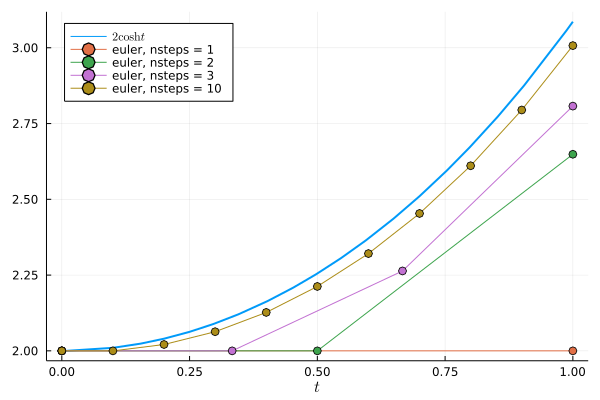

In [2]:
problem = CauchyODEProblem(
    f=(t, u) -> -u + 2exp(t),
    tstart=0,
    tend=1,
    u₀=2,
)
plt = plot(; xlabel="time", leg=:topleft)
plot!((t) -> 2cosh(t); label=L"2\cosh t", lw=2, xlabel=L"t")
for n in (1, 2, 3, 10)
    t, u = euler(problem; nsteps=n)
    plot!(t, u; label="euler, nsteps = $n", marker=:o)
end
plt

```{raw} html
</div>
```